In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import  image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import os,warnings, random,shutil
warnings.filterwarnings('ignore')

from tensorflow.keras.applications import ResNet50,EfficientNetB3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [2]:
TRAIN_DIR = "balanced_train"
TEST_DIR = "balanced_test"
postfix_name = "balanced"

In [3]:
import os

data_path=('garbage-dataset')
classes_names=os.listdir(data_path)
classes_names

['paper',
 '.DS_Store',
 'clothes',
 'metal',
 'cardboard',
 'trash',
 'glass',
 'biological',
 'battery',
 'plastic',
 'shoes']

In [4]:
out_dir=''

train_dir=os.path.join(out_dir,TRAIN_DIR)
test_dir=os.path.join(out_dir,TEST_DIR)

In [ ]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# No augmentation for validation and test sets (only rescaling)
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=100,  
    class_mode='categorical'
)

# Test Data Generator (without labels, for predictions)
test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=1,
    class_mode=None,
    shuffle=False,  # Don't shuffle test images
    seed=123
)

Found 13000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


In [6]:
class_labels=train_generator.class_indices
print(class_labels)


{'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


MODEL 1 : EfficientNetB3

In [7]:
name = "EfficientNetB3"

In [8]:
base_model=EfficientNetB3(include_top=False,pooling='avg',weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add new layers
x = Dense(128, activation='relu')(base_model.output)
x = Dense(64, activation='relu')(x)
output_layer = Dense(10, activation='softmax')(x)  # Adjust output neurons as needed

# Define the new model
model_1 = Model(inputs=base_model.input, outputs=output_layer)

In [9]:
model_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
early_stop=EarlyStopping(monitor='val_loss',patience=10)
cheackpoint=ModelCheckpoint(filepath='best.keras',monitor='val_loss',save_best_only=True,mode='auto')
history_1=model_1.fit(
           train_generator,
           steps_per_epoch=train_generator.samples//100,
           epochs=10,
           callbacks=[early_stop,cheackpoint]    
)


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.4743 - loss: 2.4206
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.7107 - loss: 1.3753
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7486 - loss: 1.3934
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.7569 - loss: 0.9556
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7595 - loss: 1.2291
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.7764 - loss: 0.9042
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.7790 - loss: 0.7905
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7936 - loss: 0.6943
Epoch 9/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.8075 - loss: 0.6394
Epoch 10/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.8121 - loss: 0.6571


In [10]:
model_1.save("model_weights/"+name+postfix_name+".h5")

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model_1.predict(test_generator)

# 4. Get true labels and predicted labels
y_true = test_generator.classes
y_pred = np.argmax(preds, axis=1)

# 5. Get class labels
class_labels = list(test_generator.class_indices.keys())

# 6. Generate classification report
print("Classification Report of:",name)
print(classification_report(y_true, y_pred, target_names=class_labels))

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 99s 33ms/step
Classification Report of: EfficientNetB3
              precision    recall  f1-score   support

     battery       0.74      0.70      0.72       300
  biological       0.76      0.60      0.67       300
   cardboard       0.79      0.73      0.76       300
     clothes       0.66      0.88      0.75       300
       glass       0.66      0.69      0.67       300
       metal       0.79      0.62      0.70       300
       paper       0.67      0.78      0.72       300
     plastic       0.74      0.71      0.72       300
       shoes       0.67      0.75      0.71       300
       trash       0.76      0.69      0.72       300

    accuracy                           0.71      3000
   macro avg       0.72      0.71      0.71      3000
weighted avg       0.72      0.71      0.71      3000



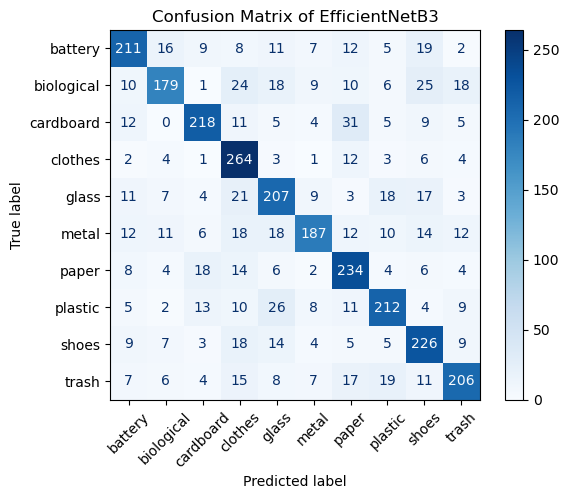

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(y_true, y_pred,labels=list(range(len(class_labels))))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix of "+name)
plt.show()

MODEL 2: Resnet101V2

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import  image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import os,warnings, random,shutil
warnings.filterwarnings('ignore')

from tensorflow.keras.applications import ResNet50,EfficientNetB3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [14]:
name = "ResNet101V2"

In [15]:
# Load the base model without the top layer
base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add new layers
x = Dense(128, activation='relu')(base_model.output)
x = Dense(64, activation='relu')(x)
output_layer = Dense(10, activation='softmax')(x)  # Adjust output neurons as needed

# Define the new model
model_2 = Model(inputs=base_model.input, outputs=output_layer)

In [16]:
model_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history_2=model_2.fit(
           train_generator,
           steps_per_epoch=train_generator.samples//100,
           epochs=10,
           callbacks=[early_stop,cheackpoint]   
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.7988 - loss: 0.6404
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.9536 - loss: 0.1416
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.9733 - loss: 0.0807
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9846 - loss: 0.0502
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.9898 - loss: 0.0330
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9965 - loss: 0.0163
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9983 - loss: 0.0105
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.9998 - loss: 0.0041
Epoch 9/10
  1/130 ━━━━━━━━━━━━━━━━━━━━ 4:04 2s/step - accuracy: 1.0000 - loss: 0.0022

KeyboardInterrupt: 

In [17]:
model_2.save("model_weights/"+name+postfix_name+".h5")

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model_2.predict(test_generator)

# 4. Get true labels and predicted labels
y_true = test_generator.classes
y_pred = np.argmax(preds, axis=1)

# 5. Get class labels
class_labels = list(test_generator.class_indices.keys())

# 6. Generate classification report
print("Classification Report of:",name)
print(classification_report(y_true, y_pred, target_names=class_labels))

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 100s 33ms/step
Classification Report of: ResNet101V2
              precision    recall  f1-score   support

     battery       0.95      0.92      0.94       300
  biological       0.98      0.97      0.97       300
   cardboard       0.92      0.96      0.94       300
     clothes       0.99      0.99      0.99       300
       glass       0.88      0.92      0.90       300
       metal       0.94      0.92      0.93       300
       paper       0.94      0.93      0.94       300
     plastic       0.92      0.89      0.90       300
       shoes       0.97      0.99      0.98       300
       trash       0.91      0.89      0.90       300

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



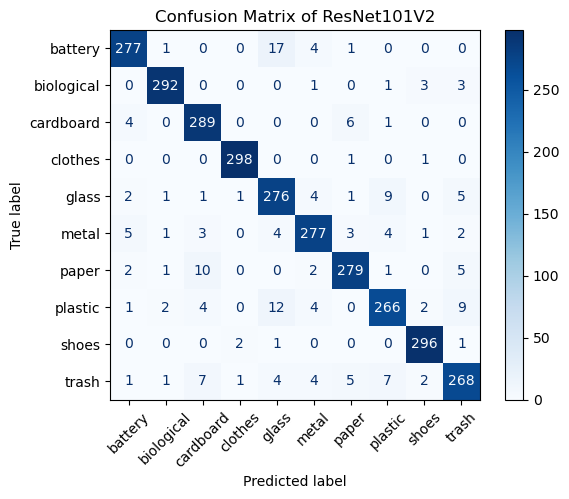

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(y_true, y_pred,labels=list(range(len(class_labels))))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix of "+name)
plt.show()

MODEL 3: Simple CNN model

In [20]:
name = "cnn"

In [21]:
model_3=Sequential()
# Block 1
model_3.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model_3.add(BatchNormalization())  
model_3.add(MaxPooling2D(pool_size=(2,2)))
# model_2.add(Dropout(0.25))  

# Block 2
model_3.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model_3.add(BatchNormalization())  
model_3.add(MaxPooling2D(pool_size=(2,2)))
# model_2.add(Dropout(0.25))

# Block 3
model_3.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model_3.add(BatchNormalization())  
model_3.add(MaxPooling2D(pool_size=(2,2)))
# model_2.add(Dropout(0.25))

# Block 4
model_3.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model_3.add(BatchNormalization())  
model_3.add(MaxPooling2D(pool_size=(2,2)))
# model_2.add(Dropout(0.25))

# Replace Flatten with Global Average Pooling
model_3.add(GlobalAveragePooling2D())

# Fully Connected Layer
model_3.add(Dense(256, activation='relu'))

# Output Layer (10 classes)
model_3.add(Dense(10, activation='softmax'))

model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,698 (1.75 MB)

 Trainable params: 457,738 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

In [22]:
model_3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history_3=model_3.fit(train_generator,epochs=10,verbose=1,)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.4792 - loss: 1.5447
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.6146 - loss: 1.1248
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.6647 - loss: 0.9847
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.6976 - loss: 0.8940
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.7254 - loss: 0.8049
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.7618 - loss: 0.7220
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.7801 - loss: 0.6536
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.8093 - loss: 0.5771
Epoch 9/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.8168 - loss: 0.5393
Epoch 10/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.8399 - loss: 0.4755


In [23]:
model_3.save("model_weights/"+name+postfix_name+".h5")

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model_3.predict(test_generator)

# 4. Get true labels and predicted labels
y_true = test_generator.classes
y_pred = np.argmax(preds, axis=1)

# 5. Get class labels
class_labels = list(test_generator.class_indices.keys())

# 6. Generate classification report
print("Classification Report of:",name)
print(classification_report(y_true, y_pred, target_names=class_labels))

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step
Classification Report of: cnn
              precision    recall  f1-score   support

     battery       0.70      0.67      0.68       300
  biological       0.85      0.85      0.85       300
   cardboard       0.80      0.78      0.79       300
     clothes       0.89      0.70      0.79       300
       glass       0.56      0.80      0.66       300
       metal       0.84      0.44      0.58       300
       paper       0.77      0.72      0.74       300
     plastic       0.58      0.68      0.63       300
       shoes       0.61      0.82      0.70       300
       trash       0.72      0.64      0.68       300

    accuracy                           0.71      3000
   macro avg       0.73      0.71      0.71      3000
weighted avg       0.73      0.71      0.71      3000



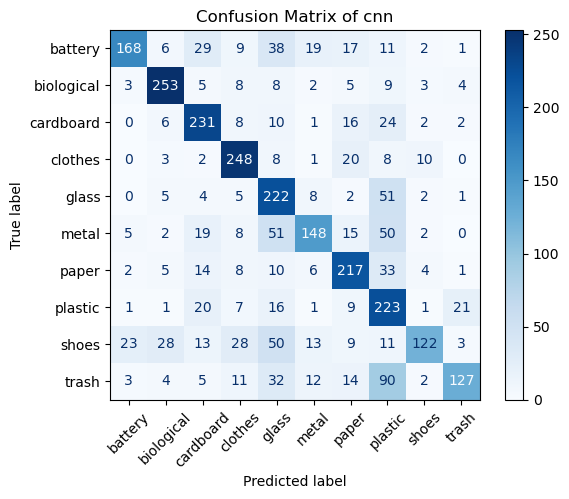

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(y_true, y_pred,labels=list(range(len(class_labels))))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix of "+name)
plt.show()

MODEL 4: CNN with dropout

In [25]:
name = "cnn_dropout"

In [26]:
model_4=Sequential()
# Block 1
model_4.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model_4.add(BatchNormalization())  
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))  

# Block 2
model_4.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model_4.add(BatchNormalization())  
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))

# Block 3
model_4.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model_4.add(BatchNormalization())  
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))

# Block 4
model_4.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model_4.add(BatchNormalization())  
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.25))

# Replace Flatten with Global Average Pooling
model_4.add(GlobalAveragePooling2D())

# Fully Connected Layer
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))

# Output Layer (10 classes)
model_4.add(Dense(10, activation='softmax'))

model_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,698 (1.75 MB)

 Trainable params: 457,738 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

In [27]:
model_4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history_4=model_4.fit(train_generator,epochs=10,verbose=1,)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.3879 - loss: 1.8846
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.5364 - loss: 1.3744
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.5931 - loss: 1.2237
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.6169 - loss: 1.1392
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.6480 - loss: 1.0520
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.6663 - loss: 0.9986
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.7015 - loss: 0.9053
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.7028 - loss: 0.8878
Epoch 9/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7262 - loss: 0.8166
Epoch 10/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.7470 - loss: 0.7633


In [28]:
model_4.save("model_weights/"+name+postfix_name+".h5")

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model_4.predict(test_generator)

# 4. Get true labels and predicted labels
y_true = test_generator.classes
y_pred = np.argmax(preds, axis=1)

# 5. Get class labels
class_labels = list(test_generator.class_indices.keys())

# 6. Generate classification report
print("Classification Report of:",name)
print(classification_report(y_true, y_pred, target_names=class_labels))

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step
Classification Report of: cnn_dropout
              precision    recall  f1-score   support

     battery       0.83      0.15      0.25       300
  biological       0.32      0.90      0.47       300
   cardboard       0.79      0.37      0.50       300
     clothes       0.38      0.83      0.52       300
       glass       0.43      0.40      0.41       300
       metal       0.73      0.14      0.23       300
       paper       0.56      0.44      0.49       300
     plastic       0.58      0.31      0.41       300
       shoes       0.36      0.57      0.44       300
       trash       0.76      0.25      0.38       300

    accuracy                           0.43      3000
   macro avg       0.57      0.43      0.41      3000
weighted avg       0.57      0.43      0.41      3000



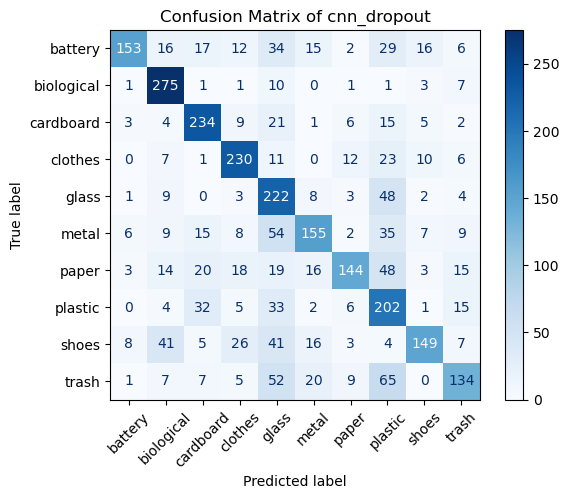

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(y_true, y_pred,labels=list(range(len(class_labels))))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix of "+name)
plt.show()